# Introduction

X (formerly Twitter) is a critical communication tool for real-time updates in emergencies, making the ability to process and understand the meaning of tweets very important. Many organizations use Twitter to be alerted of new disasters, and by quickly pinpointing new disasters, these organizations can jumpstart themselves into action.

The goal of this project is to make a model similar to what these organizations use. It will utilize natural language processing (NLP) to parse through tweets and a recurrent neural network (RNN) to learn the differences between actual disaster tweets and all other tweets. This project will trial multiple different RNN architectures. In the end, the model will be able to predict which tweets are about an actual disaster and which ones are not.

# Data
The dataset comes from Kaggle at this link: https://www.kaggle.com/competitions/nlp-getting-started/data

The data is split into a training and test data set. There are 7,613 samples in the training set, and 3,263 sample in the test set (10,000 samples total). 

The labels of the training set are 1 if the tweet is about a real disaster and 0 if not. The goal will be to train a model to be able to accurately predict if the tweets in the test set are about a real disaster or not. 

We will look more into the data below:

In [69]:
#import all necessary libraries
import itertools
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import math
import re

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten,Embedding,Dense, Dropout, LSTM, Bidirectional, SimpleRNN, GRU

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.initializers import Constant

In [2]:
#read in train and testing data to dfs
train_data = pd.read_csv("nlp-disaster tweets/train.csv")
test_data = pd.read_csv("nlp-disaster tweets/test.csv")

#show the info of dataframes and sample of train data
test_data.info()
train_data.info()

train_data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


There are four features in the dataset: id, keyword, location, and text. The id is just the id of the tweet. The keyword is a keyword from the tweet (this can be blank). The location is the location the tweet was sent from (this can be blank). The text is the tweet itself. 

For the training set, there are 61 missing values for keyword, and 2,533 missing values for location. 

In [58]:
print("Missing values for keyword in training set: ", sum(train_data['keyword'].isnull()))
print("Missing values for location in training set: ", sum(train_data['location'].isnull()))
#train_data.isnull().sum()

Missing values for keyword in training set:  61
Missing values for location in training set:  2533


Text(0.5, 1.0, 'Histogram of labels for training data')

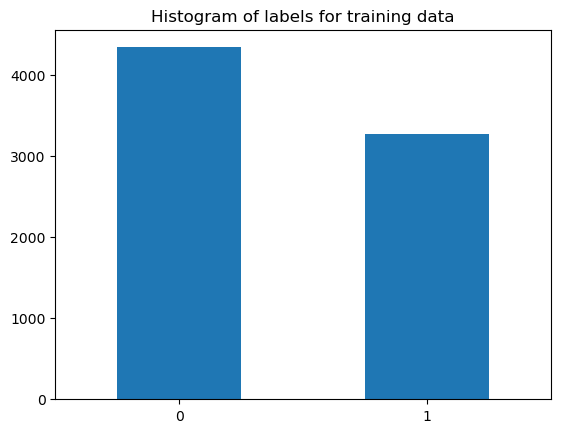

In [4]:
#Put labels into variable
y_train = train_data['target']

#histogram for Category column
train_data['target'].value_counts().plot(kind='bar',rot=0)
plt.title("Histogram of labels for training data")

The distribution of labels is not perfectly balanced, but it is not severely unbalanced either. This is good news for our model building because a dataset with a unbalanced distribution can lead to a bias. 

Next we will look at the frequencies of the keywords and locations to see if we think this will be useful information for a model. We will also look to see if the keyword is included in the text itself. 

The number of unique keywords:  221


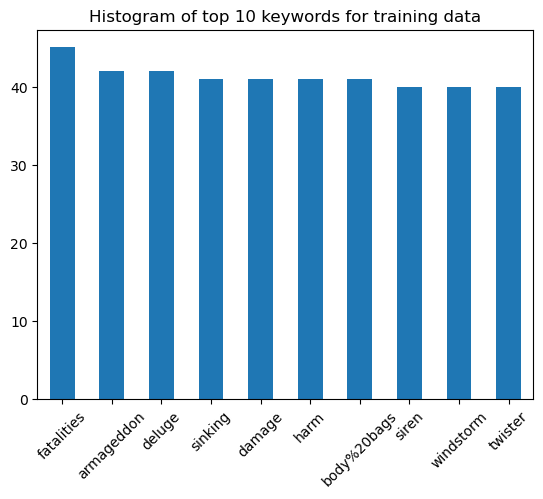

In [5]:
#Put keyword and location into variable
x_kl_train = train_data[['keyword','location']]

#histogram for keywords
x_kl_train['keyword'].value_counts().sort_values( ascending = False).iloc[:10].plot(kind='bar',rot = 45)
plt.title("Histogram of top 10 keywords for training data")

#print the number of differen keywords
print("The number of unique keywords: ", len(x_kl_train['keyword'].unique())-1)

In [6]:
#define a function to check if the keyword is in the text
def keyword_in_text(row):
    '''
    This function will be used in a df.apply()
    row is a row of df
    '''
    #if the keyword is a string (not NaN), check if keyword in text
    if type(row['keyword']) == str:
        return int(row['keyword'] in row['text'].lower())
    #if not, return o
    else: 
        return 0

In [7]:
#apply above function to train_data to see how many keyowrds are 
#in the text column
train_data['kw_in_txt'] = train_data.apply(keyword_in_text, axis=1)
print("Number of rows with keyword in text: ", len(train_data[train_data['kw_in_txt'] == 1]))
print("Number of rows with keyword not in text: ", len(train_data[train_data['kw_in_txt'] == 0]))

#example of keyword not in text
kw_not_text = train_data[train_data['kw_in_txt'] == 0]
print("\nhere is an example of the keyword not being in the text")
print("keyword: ",kw_not_text.iloc[0,:]['keyword'])
print("text: ",kw_not_text.iloc[0,:]['text'])

Number of rows with keyword in text:  5973
Number of rows with keyword not in text:  1579

here is an example of the keyword not being in the text
keyword:  ablaze
text:  We always try to bring the heavy. #metal #RT http://t.co/YAo1e0xngw


There are 221 unique keywords and from the histogram, and we can see that no keyword is very common. The top used keyword is used ~45 times.

There are 5,973 rows that have the keyword included in the text, and only 1,579 without the keyword in text. From the example of a keyword not in the text shown above, it looks like the keyword does not provide a lot of context, or is possibly wrongly applied. For these reasons, keyword will not be used in our models. 

For location, there are 3341 unique locations, with the top 10 consisting of countries or places in the USA. This does not seem like it will be a helpful feature in the model. First, there are way too many locations for the quantity of data we have. Second, a disaster can happen anywhere and we don't want to train a model to predict based on historical locations. 

The number of unique locations:  3341


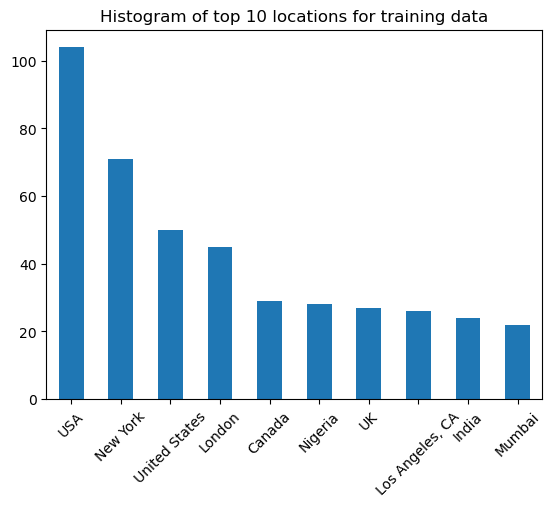

In [8]:
#histogram for Category column
x_kl_train['location'].value_counts().sort_values( ascending = False).iloc[:10].plot(kind='bar',rot = 45)
plt.title("Histogram of top 10 locations for training data")

print("The number of unique locations: ", len(x_kl_train['location'].unique())-1)

Now we we will look at a a few different distributions comparing not-disaster (0) vs disaster (1) tweets. We will look at the distributions of word count, character count, and average length of word.

In [9]:
#count the number of words, characters, and average word length in the text of each article
train_data['Word Count'] = train_data.apply(lambda row : len(row['text'].split()), axis= 1)
train_data['Character Count'] = train_data.apply(lambda row : len(row['text']), axis= 1)
train_data['Average Word Length'] = train_data.apply(lambda row : row['Character Count']/row['Word Count'], axis= 1)


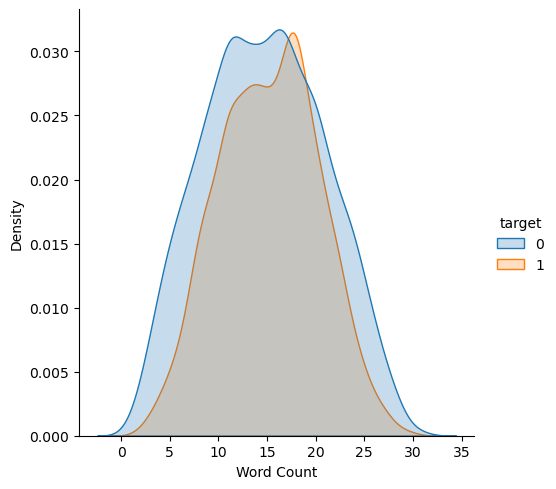

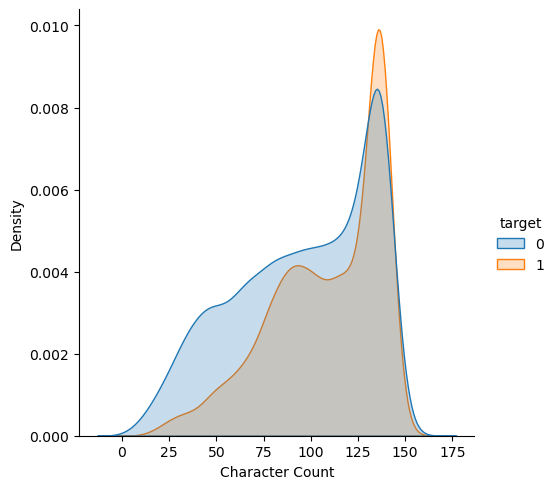

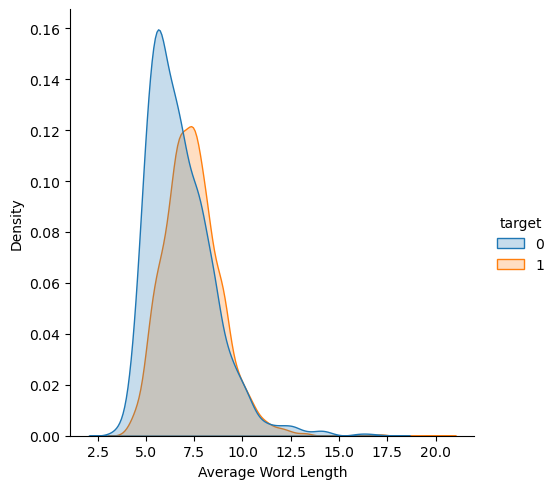

In [10]:
#create distribution plots with the above data
sns.displot(data = train_data, x = 'Word Count', hue = 'target', kind='kde', fill = True)
sns.displot(data = train_data, x = 'Character Count', hue = 'target', kind='kde', fill = True)
sns.displot(data = train_data, x = 'Average Word Length', hue = 'target', kind='kde', fill = True)

The word counts between the categories are very similar. The average character count is higher for real disaster tweets. The average word length is higher for real disaster tweets. This may be because disaster tweets are from accounts like news organizations, are serious, and have less abbreviations/slang. This information could be useful when trying to classify our data with the models. 

# Data Preprocessing and Plan of Analysis

There are a lot of different steps you can do to text data to clean it up, such as: removing punctuation, removing special characters, removing stop words, removing emjois, removing websites, among others. We will intially try our models with close to the original text, with only these preprocessing steps applied: making text lowercase, and adding a space between letters and special characters/punctuation. Then we will fit another round of models with cleaned data. The preprocessing steps we will do for the clean data are: making text lowercase, remove urls, remove special characters, remove punctuation, and remove emojis. 

We will then tokenize our text, and transform the text to sequences for the computer to understand. Then we will create an embedding dictionary using GloVe for the words we have in our set of texts. We will do each of these steps twice, once on the "orginal" data and once on the cleaned data. 

We will discuss the tokenization and GloVe again at a later step.

In [11]:
def clean_text(df, clean_level = 0):
    '''
    df = df to clean
    clean_level = 0 for minimal cleaning or 1 for more cleaning
    retuns train and test data cleaned
    '''
    #copy df so doesn't change orgininal
    df1 = df.copy()
    
    #first make all characters lowercase
    df1['text'] = df1.apply(lambda row: row['text'].lower(), axis = 1) 
    
    #if basic cleaning, do these steps
    if clean_level == 0:
        #add space to all special characters and punctionation
        df1['text'] = df1.apply(lambda row: re.sub(r"([!@#$%^&*()|;,./?><])"," \\1 ",row['text']), axis = 1) 

        #remove apostrophes so contractions still one word
        df1['text'] = df1.apply(lambda row: re.sub("\'","",row['text']), axis = 1) 
    #if more thorough cleaning, do thest steps
    else:
        #remove urls
        df1['text'] = df1.apply(lambda row:re.sub(r'http\S+','',row['text']), axis = 1)

        #remove all special characters and punctuation (including apostrophes)
        df1['text'] = df1.apply(lambda row: re.sub(r"([!@#$%^&*()|;,./?><\'])","",row['text']), axis = 1) 

        #remove emojis
        emojis = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)

        df1['text'] = df1.apply(lambda row:re.sub(emojis,'',row['text']), axis = 1) 


    #show differences and return df
    print(df['text'].head())
    print(df1['text'].head())
    
    return df1

In [12]:
#Show example of the cleaning
print("Examples of training example before and after minimal cleaning:")
train_data1 = clean_text(train_data)
print("\nExamples of test example before and after minimal cleaning:")
test_data1 = clean_text(test_data)

Examples of training example before and after minimal cleaning:
0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    Just got sent this photo from Ruby #Alaska as ...
Name: text, dtype: object
0    our deeds are the reason of this  # earthquake...
1             forest fire near la ronge sask .  canada
2    all residents asked to shelter in place are be...
3    13 , 000 people receive  # wildfires evacuatio...
4    just got sent this photo from ruby  # alaska a...
Name: text, dtype: object

Examples of test example before and after minimal cleaning:
0                   Just happened a terrible car crash
1    Heard about #earthquake is different cities, s...
2    there is a forest fire at spot pond, geese are...
3             Apocalypse lighting. #Spokane #wildfires
4        Typhoon Soudelor kills 28 in China and Taiwa

In [13]:
print("Examples of training example before and after cleaning:")
train_data_clean = clean_text(train_data, 1)
print("\nExamples of test example before and after cleaning:")
test_data_clean = clean_text(test_data, 1)

Examples of training example before and after cleaning:
0    Our Deeds are the Reason of this #earthquake M...
1               Forest fire near La Ronge Sask. Canada
2    All residents asked to 'shelter in place' are ...
3    13,000 people receive #wildfires evacuation or...
4    Just got sent this photo from Ruby #Alaska as ...
Name: text, dtype: object
0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3    13000 people receive wildfires evacuation orde...
4    just got sent this photo from ruby alaska as s...
Name: text, dtype: object

Examples of test example before and after cleaning:
0                   Just happened a terrible car crash
1    Heard about #earthquake is different cities, s...
2    there is a forest fire at spot pond, geese are...
3             Apocalypse lighting. #Spokane #wildfires
4        Typhoon Soudelor kills 28 in China and Taiwan
Name: text, dt

Now we have our two different datasets: one original with minimal cleaning, and the other with more cleaning. We will now tokenize our text. 

# Tokenzing and GloVe
The TensorFlow Tokenizer class allows you to vectorize text into a sequence of integers. These sequence of integers then can be read and understood by a computer. To use the Tokenizer class, you first begin an instance of it. Then you can fit the instance on a list of texts (this is what we have: a list of tweets). This fit function updates the internal vocavularly based on the words in the texts. It creates a dictionary with the frequency of each word. We can then use this to turn our texts into sequences. 

We will also be using GloVe (which is a Standford project for "Global Vectors for Word Representation") as our pre-trained word embeddings. GloVe is a very popular embedding and it was trained on global word-word co-occurence satistics. The version we will be using is the one with 6 billion tokens and 100 dimensions. We get our embeddings from GloVe by going through each word in our vocab dictionary from tokenization and if a word matches a word in GloVe, we copy the vector from GloVe to our embedding matrix. If there is no match in GloVe, then the embedding matrix will be zeros for that word. These embeddings will then be used in the RNN. Again, this needs to be performed twice, once on each dataset. 

In [14]:
# create tokenizer and fit to texts
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data1['text'])
  
#get word_index and print number of words in index
word_index = tokenizer.word_index
print("Number of unique words in dictionary=", len(word_index))
#print("Dictionary is = ", tokenizer.word_index)

Number of unique words in dictionary= 22083


In [15]:
#Set vocab_size as number of words from tokenization
vocab_size = len(word_index) + 1
#We are choosing the 100D version of GloVe
embedding_dim = 100
#initialize embedding matrix with the number of rows of
#vocab size and embedding_dim as column size
embedding_matrix_vocab = np.zeros((vocab_size,embedding_dim))

#set filepath where GloVe 100D is located
filepath = 'glove.6B/glove.6B.100d.txt'

#open the GloVe txt file
with open(filepath,'r', encoding="utf8") as f:
    #loop through each line
    for line in f:
        #split line to word and its vector
        word, *vector = line.split()
        #if the word is in our word_index,
        #add the associated GloVe vector to our matrix
        if word in word_index:
            #get index of word in our word_index
            idx = word_index[word]
            #update embedding matrix at that index to have
            #the Glove vector
            embedding_matrix_vocab[idx] = np.array(
                vector, dtype=np.float32)[:embedding_dim]
            
#show one example of the embedding vector
print("Dense vector for first word is => ",embedding_matrix_vocab[1])

Dense vector for first word is =>  [ 0.13482     0.40224001 -0.42265999 -0.055631   -0.55742002  0.043634
  0.049172    0.17382    -0.74579    -0.11306     0.19373    -0.0612
 -0.04722     0.61628997  0.16717     0.18415     0.17518     0.032346
  0.87703001 -0.29756001  0.47646001 -0.031404    0.36258999  0.50297999
  0.20622     1.13629997  0.039542   -0.26769999  0.15408    -0.77929002
  1.15670002  1.42219996 -0.21405999 -0.081809    0.53378999  0.069233
  0.18365     0.21626     0.18494999  0.51840001  1.26250005 -0.39466
  0.0044504  -0.61466002 -0.86791998  0.17854001 -0.64734     0.92421001
  0.10692    -0.50519001  0.27298999  0.053007    0.36574     0.013988
 -0.41345999 -1.70550001 -0.67447001  0.62946999  1.62720001  0.37147
 -0.52477002 -0.21547    -0.50581998 -0.33827001  0.63836998  0.90878999
  0.51358998  0.61179     0.47222     0.36789     0.30193001 -0.027832
 -0.94010001 -0.85706002  0.61206001 -0.17894     0.71162999  0.35246
 -0.53997999 -0.40487     0.73280001 -1

In [16]:
#find sequences for dataset to inut into RNN model
sequences = tokenizer.texts_to_sequences(train_data1['text'])
#pad the sequences so they are all same length
pad_seq = pad_sequences(sequences)
print('Shape of padded sequence tensor:', pad_seq.shape)
print('Shape of target tensor:', y_train.shape)
#save the length of sequence to use in RNN
seq_length = pad_seq.shape[1]

#find sequences for test set
sequences_test = tokenizer.texts_to_sequences(test_data1['text'])
pad_seq_test = pad_sequences(sequences_test, maxlen = seq_length)

Shape of padded sequence tensor: (7613, 33)
Shape of target tensor: (7613,)


In [17]:
#same process, but for cleaned data
# create tokenizer and fit to texts
tokenizer2 = Tokenizer()
tokenizer2.fit_on_texts(train_data_clean['text'])
  
#get word_index and print number of words in index
word_index2 = tokenizer2.word_index
print("Number of unique words in dictionary=", len(word_index2))
#print("Dictionary is = ", tokenizer.word_index)

Number of unique words in dictionary= 17800


In [18]:
#Set vocab_size as number of words from tokenization
vocab_size2 = len(word_index2) + 1
embedding_dim = 100
embedding_matrix_vocab2 = np.zeros((vocab_size2,embedding_dim))

filepath = 'glove.6B/glove.6B.100d.txt'

#see above code block for comments, should have made function....
with open(filepath,'r', encoding="utf8") as f:
    for line in f:
        word, *vector = line.split()
        if word in word_index2:
            idx = word_index2[word]
            embedding_matrix_vocab2[idx] = np.array(
                vector, dtype=np.float32)[:embedding_dim]

print("Dense vector for first word is => ",
embedding_matrix_vocab2[1])

Dense vector for first word is =>  [-0.038194   -0.24487001  0.72812003 -0.39961001  0.083172    0.043953
 -0.39140999  0.3344     -0.57545     0.087459    0.28786999 -0.06731
  0.30906001 -0.26383999 -0.13231    -0.20757     0.33395001 -0.33848
 -0.31742999 -0.48335999  0.1464     -0.37303999  0.34577     0.052041
  0.44946    -0.46970999  0.02628    -0.54154998 -0.15518001 -0.14106999
 -0.039722    0.28277001  0.14393     0.23464    -0.31020999  0.086173
  0.20397     0.52623999  0.17163999 -0.082378   -0.71787    -0.41531
  0.20334999 -0.12763     0.41367     0.55186999  0.57907999 -0.33476999
 -0.36559001 -0.54856998 -0.062892    0.26583999  0.30204999  0.99774998
 -0.80480999 -3.0243001   0.01254    -0.36941999  2.21670008  0.72201002
 -0.24978     0.92136002  0.034514    0.46744999  1.10790002 -0.19358
 -0.074575    0.23353    -0.052062   -0.22044     0.057162   -0.15806
 -0.30798    -0.41624999  0.37972     0.15006    -0.53211999 -0.20550001
 -1.25259995  0.071624    0.70564997 

In [19]:
#find sequences for dataset to inut into RNN model
sequences2 = tokenizer2.texts_to_sequences(train_data_clean['text'])
pad_seq2 = pad_sequences(sequences2)
print('Shape of padded sequence tensor:', pad_seq2.shape)
print('Shape of target tensor:', y_train.shape)
seq_length2 = pad_seq2.shape[1]

#find sequences for test set
sequences_test2 = tokenizer2.texts_to_sequences(test_data_clean['text'])
pad_seq_test2 = pad_sequences(sequences_test2, maxlen = seq_length2)

Shape of padded sequence tensor: (7613, 31)
Shape of target tensor: (7613,)


# Modeling
We will create three different models for each of our data sets (a total of 6 models). The three models are:

1. Simple RNN - We will start with a simple RNN model because it is the most basic RNN and will provide a baseline. This will probably be the worst performing model because it has some limitations that the other models address. 
2. LSTM (with bidirectional) - we will then use Long Short-Term Memory (LSTM) with bidirectional. This allows the model to process input in opposite directions, both forward and backward. This model should provide better results than simple RNN.
3. GRU (with bidirectional) - the last model ill be Gated Recurrent Unit (GRU) with bidirectional. This model should also provide better results than simple RNN since it addresses some of the limitations, but may provide similar results to LSTM. 

We will fit these 3 models to both of our data sets and then analyze the results.

In [20]:
def createmodel(modeltype, clean_data = True, n = 100, bidir = False):
    '''
    This function creates an RNN model with the specific 
    RNN layer that you want.
    
    modeltype = sRNN, LSTM, or GRU as string
    clean_data = if data source should be the clean data or not
    n = units for output of RNN layer
    bidir = Bidirectional RNN layer
    
    returns model
    '''
    #initliaze sequential model
    model = Sequential()
    
    #if data is clean, use its associate embedding layer
    if clean_data:
        #this layer is not trainable because we got our embeddings from GloVe
        embedding_layer = Embedding(vocab_size2,embedding_dim,embeddings_initializer=Constant(embedding_matrix_vocab2),
                                input_length=seq_length2,trainable=False)
    #else use the other data's embedding layer
    else: 
        embedding_layer = Embedding(vocab_size,embedding_dim,embeddings_initializer=Constant(embedding_matrix_vocab),
                                input_length=seq_length,trainable=False)
    
    #add embedding layer to model
    model.add(embedding_layer)
    
    #add the specific type of RNN layer to model
    if modeltype == 'sRNN':
        model.add(SimpleRNN(n))
    elif modeltype == 'LSTM':
        if bidir:
            model.add(Bidirectional(LSTM(n, dropout=0.2, recurrent_dropout=0.2)))
        else:
            model.add(LSTM(n, dropout=0.2, recurrent_dropout=0.2))
    elif modeltype == 'GRU':
        if bidir:
            model.add(Bidirectional(GRU(n, dropout=0.2, recurrent_dropout=0.2)))
        else:
            model5.add(GRU(n, dropout = 0.2, recurrent_dropout=0.2))
    
    #add remaining layers and compile model
    model.add(Dropout(0.2))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])
    
    return model

In [21]:
#create function to create graphs of accuracy/loss
#for use later on
def modelGraphs(history, plttiltle):
    '''
    This function graphs the metrics from the history of a model
    
    history = history of a model.fit()
    plttilte = start of title for plots in function
    '''
    #make subplots for plots to be side by side
    fig, axs = plt.subplots(1, 2, figsize=(10,4))
    #spread subplot away from each other 
    plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
    i = 0
    #Loop through each metric to make plot
    for metric in history.history.keys():
        #if metric has "val" in it, stop
        if metric.find('val') >= 0:
            break
        #make val_metric
        val_metric = "val_" + metric
        #plot metric
        axs[i].plot(np.arange(1,len(history.history[metric]) + 1),history.history[metric])
        #plot validation data metric
        axs[i].plot(np.arange(1,len(history.history[val_metric]) + 1),history.history[val_metric])
        
        #add title, axes labels and legend
        #title_options = ['Base Model', 'Extended Model', 'ResNet50 Model']
        axs[i].set_title(plttiltle +": Epoch vs " + metric)
        axs[i].set_ylabel(metric)
        axs[i].set_xlabel('Epoch Number')
        axs[i].legend(['Train', 'Validate'], loc='best')
        #increment count
        i+= 1

In [22]:
#create first model and show summary
model1 = createmodel('sRNN', clean_data = False, n = 100, bidir = False)
print(model1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 33, 100)           2208400   
                                                                 
 simple_rnn (SimpleRNN)      (None, 100)               20100     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 2,228,601
Trainable params: 20,201
Non-trainable params: 2,208,400
_________________________________________________________________
None


In [23]:
#fit first model
history1 = model1.fit(pad_seq, y_train, validation_split = .2,epochs = 10, verbose = 1)

Epoch 1/10
191/191 [==============================] - 3s 10ms/step - loss: 0.5505 - acc: 0.7330 - val_loss: 0.4720 - val_acc: 0.7919
Epoch 2/10
191/191 [==============================] - 2s 9ms/step - loss: 0.4723 - acc: 0.7974 - val_loss: 0.4571 - val_acc: 0.7912
Epoch 3/10
191/191 [==============================] - 2s 9ms/step - loss: 0.4441 - acc: 0.8117 - val_loss: 0.4625 - val_acc: 0.7965
Epoch 4/10
191/191 [==============================] - 1s 8ms/step - loss: 0.4289 - acc: 0.8212 - val_loss: 0.4572 - val_acc: 0.7971
Epoch 5/10
191/191 [==============================] - 1s 7ms/step - loss: 0.4076 - acc: 0.8320 - val_loss: 0.4558 - val_acc: 0.7951
Epoch 6/10
191/191 [==============================] - 1s 7ms/step - loss: 0.3888 - acc: 0.8350 - val_loss: 0.4987 - val_acc: 0.7886
Epoch 7/10
191/191 [==============================] - 1s 7ms/step - loss: 0.3674 - acc: 0.8498 - val_loss: 0.4862 - val_acc: 0.7840
Epoch 8/10
191/191 [==============================] - 1s 7ms/step - loss: 0

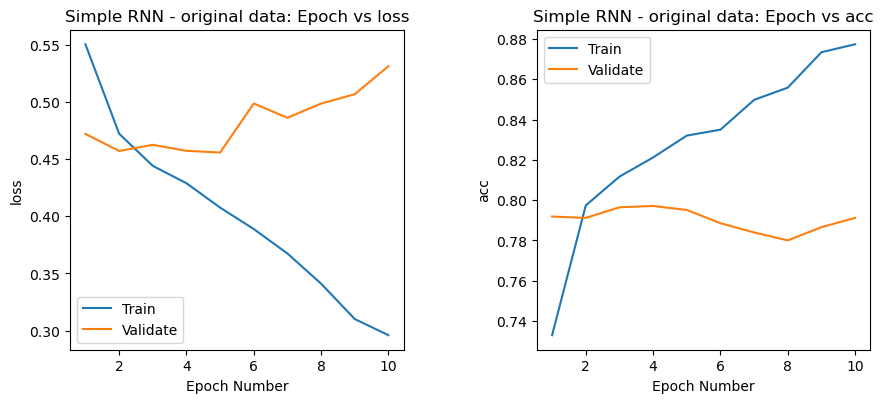

In [24]:
#graph first model
modelGraphs(history1, "Simple RNN - original data")

In [25]:
model2 = createmodel('LSTM', clean_data = False, n = 100, bidir = True)
print(model2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 33, 100)           2208400   
                                                                 
 bidirectional (Bidirectiona  (None, 200)              160800    
 l)                                                              
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 201       
                                                                 
Total params: 2,369,401
Trainable params: 161,001
Non-trainable params: 2,208,400
_________________________________________________________________
None


Epoch 1/10
191/191 [==============================] - 18s 64ms/step - loss: 0.4947 - acc: 0.7709 - val_loss: 0.4479 - val_acc: 0.7997
Epoch 2/10
191/191 [==============================] - 12s 64ms/step - loss: 0.4421 - acc: 0.7979 - val_loss: 0.4276 - val_acc: 0.8135
Epoch 3/10
191/191 [==============================] - 11s 60ms/step - loss: 0.4172 - acc: 0.8172 - val_loss: 0.4363 - val_acc: 0.7984
Epoch 4/10
191/191 [==============================] - 12s 60ms/step - loss: 0.4084 - acc: 0.8228 - val_loss: 0.4140 - val_acc: 0.8122
Epoch 5/10
191/191 [==============================] - 12s 63ms/step - loss: 0.3968 - acc: 0.8296 - val_loss: 0.4176 - val_acc: 0.8181
Epoch 6/10
191/191 [==============================] - 12s 63ms/step - loss: 0.3856 - acc: 0.8360 - val_loss: 0.4475 - val_acc: 0.8168
Epoch 7/10
191/191 [==============================] - 12s 62ms/step - loss: 0.3740 - acc: 0.8409 - val_loss: 0.4548 - val_acc: 0.7958
Epoch 8/10
191/191 [==============================] - 12s 61ms

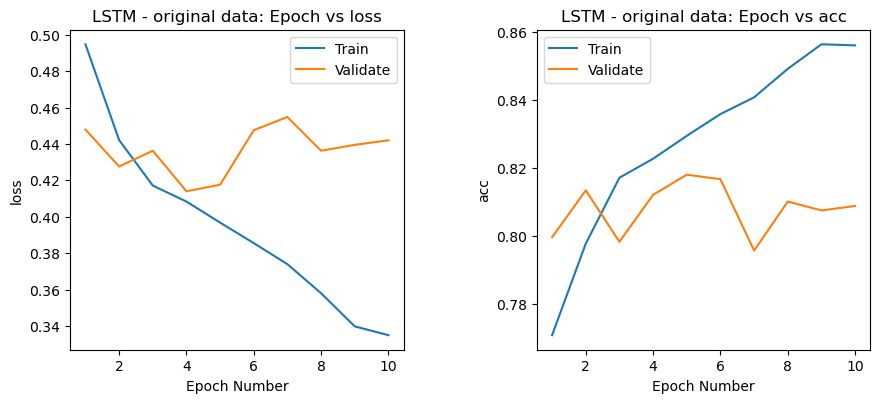

In [26]:
history2 = model2.fit(pad_seq, y_train, validation_split = .2,epochs = 10, verbose = 1)
modelGraphs(history2, "LSTM - original data")

In [27]:
model3 = createmodel('GRU', clean_data = False, n = 100, bidir = True)
print(model3.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 33, 100)           2208400   
                                                                 
 bidirectional_1 (Bidirectio  (None, 200)              121200    
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 200)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 201       
                                                                 
Total params: 2,329,801
Trainable params: 121,401
Non-trainable params: 2,208,400
_________________________________________________________________
None


Epoch 1/10
191/191 [==============================] - 15s 52ms/step - loss: 0.5300 - acc: 0.7353 - val_loss: 0.4313 - val_acc: 0.8004
Epoch 2/10
191/191 [==============================] - 9s 49ms/step - loss: 0.4444 - acc: 0.8016 - val_loss: 0.4193 - val_acc: 0.8109
Epoch 3/10
191/191 [==============================] - 10s 52ms/step - loss: 0.4256 - acc: 0.8148 - val_loss: 0.4184 - val_acc: 0.8037
Epoch 4/10
191/191 [==============================] - 10s 51ms/step - loss: 0.4139 - acc: 0.8171 - val_loss: 0.4112 - val_acc: 0.8109
Epoch 5/10
191/191 [==============================] - 10s 50ms/step - loss: 0.4035 - acc: 0.8227 - val_loss: 0.4300 - val_acc: 0.7945
Epoch 6/10
191/191 [==============================] - 9s 50ms/step - loss: 0.3953 - acc: 0.8310 - val_loss: 0.4350 - val_acc: 0.7938
Epoch 7/10
191/191 [==============================] - 9s 49ms/step - loss: 0.3897 - acc: 0.8332 - val_loss: 0.4147 - val_acc: 0.8076
Epoch 8/10
191/191 [==============================] - 10s 50ms/st

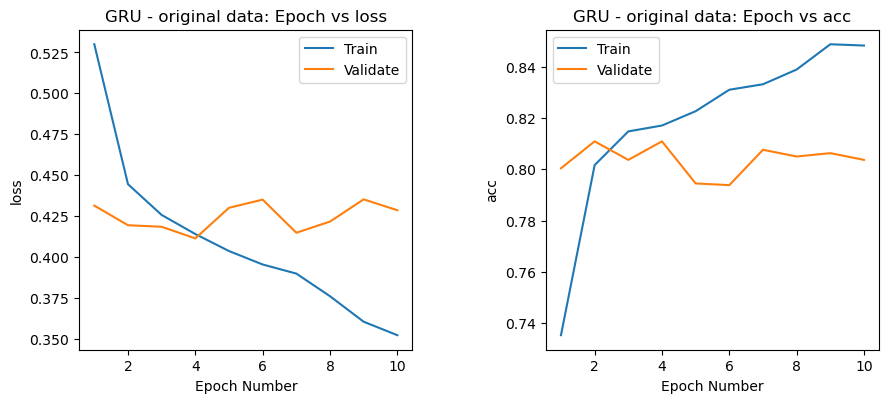

In [28]:
history3 = model3.fit(pad_seq, y_train, validation_split = .2,epochs = 10, verbose = 1)
modelGraphs(history3, "GRU - original data")

In [29]:
model4 = createmodel('sRNN', clean_data = True, n = 100, bidir = False)
print(model4.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 31, 100)           1780100   
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 100)               20100     
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 1,800,301
Trainable params: 20,201
Non-trainable params: 1,780,100
_________________________________________________________________
None


Epoch 1/10
191/191 [==============================] - 3s 11ms/step - loss: 0.5410 - acc: 0.7394 - val_loss: 0.4483 - val_acc: 0.8037
Epoch 2/10
191/191 [==============================] - 2s 10ms/step - loss: 0.4675 - acc: 0.7931 - val_loss: 0.4582 - val_acc: 0.7958
Epoch 3/10
191/191 [==============================] - 2s 10ms/step - loss: 0.4460 - acc: 0.8054 - val_loss: 0.4569 - val_acc: 0.8056
Epoch 4/10
191/191 [==============================] - 2s 10ms/step - loss: 0.4193 - acc: 0.8177 - val_loss: 0.4797 - val_acc: 0.7774
Epoch 5/10
191/191 [==============================] - 2s 10ms/step - loss: 0.4078 - acc: 0.8253 - val_loss: 0.4722 - val_acc: 0.7997
Epoch 6/10
191/191 [==============================] - 1s 7ms/step - loss: 0.3893 - acc: 0.8332 - val_loss: 0.4857 - val_acc: 0.7774
Epoch 7/10
191/191 [==============================] - 1s 6ms/step - loss: 0.3583 - acc: 0.8453 - val_loss: 0.5264 - val_acc: 0.7846
Epoch 8/10
191/191 [==============================] - 1s 7ms/step - los

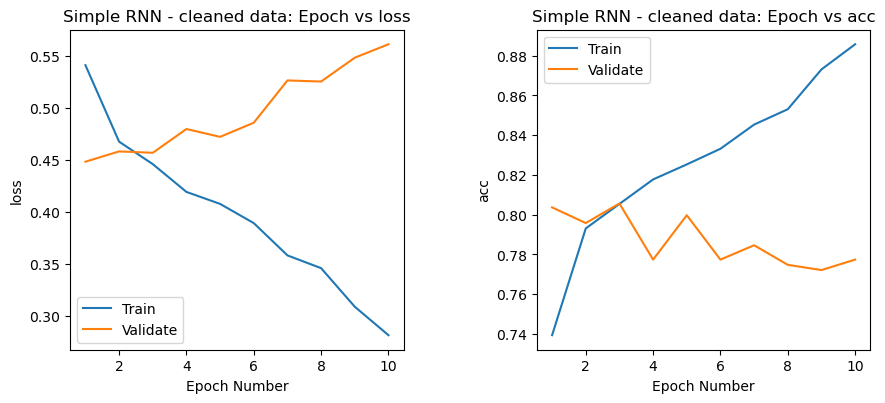

In [30]:
history4 = model4.fit(pad_seq2, y_train, validation_split = .2,epochs = 10, verbose = 1)
modelGraphs(history4, "Simple RNN - cleaned data")

In [31]:
model5 = createmodel('LSTM', clean_data = True, n = 100, bidir = True)
print(model5.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 31, 100)           1780100   
                                                                 
 bidirectional_2 (Bidirectio  (None, 200)              160800    
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 200)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                 201       
                                                                 
Total params: 1,941,101
Trainable params: 161,001
Non-trainable params: 1,780,100
_________________________________________________________________
None


Epoch 1/10
191/191 [==============================] - 18s 56ms/step - loss: 0.4938 - acc: 0.7708 - val_loss: 0.4507 - val_acc: 0.7912
Epoch 2/10
191/191 [==============================] - 13s 66ms/step - loss: 0.4448 - acc: 0.8025 - val_loss: 0.4180 - val_acc: 0.8122
Epoch 3/10
191/191 [==============================] - 12s 62ms/step - loss: 0.4271 - acc: 0.8136 - val_loss: 0.4331 - val_acc: 0.8070
Epoch 4/10
191/191 [==============================] - 10s 53ms/step - loss: 0.4187 - acc: 0.8149 - val_loss: 0.4343 - val_acc: 0.8017
Epoch 5/10
191/191 [==============================] - 10s 53ms/step - loss: 0.3994 - acc: 0.8294 - val_loss: 0.4234 - val_acc: 0.8056
Epoch 6/10
191/191 [==============================] - 10s 52ms/step - loss: 0.3916 - acc: 0.8319 - val_loss: 0.4203 - val_acc: 0.8122
Epoch 7/10
191/191 [==============================] - 10s 52ms/step - loss: 0.3750 - acc: 0.8407 - val_loss: 0.4659 - val_acc: 0.8063
Epoch 8/10
191/191 [==============================] - 10s 52ms

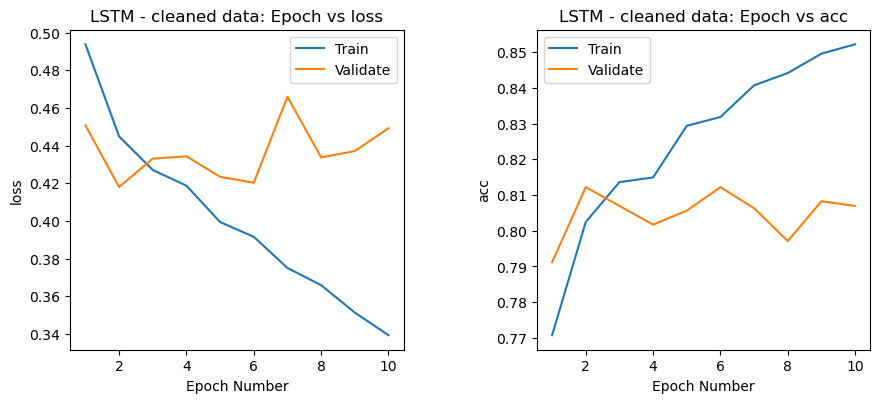

In [32]:
history5 = model5.fit(pad_seq2, y_train, validation_split = .2,epochs = 10, verbose = 1)
modelGraphs(history5, "LSTM - cleaned data")

In [33]:
model6 = createmodel('GRU', clean_data = True, n = 100, bidir = True)
print(model6.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 31, 100)           1780100   
                                                                 
 bidirectional_3 (Bidirectio  (None, 200)              121200    
 nal)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 200)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 201       
                                                                 
Total params: 1,901,501
Trainable params: 121,401
Non-trainable params: 1,780,100
_________________________________________________________________
None


Epoch 1/10
191/191 [==============================] - 15s 47ms/step - loss: 0.5101 - acc: 0.7534 - val_loss: 0.4336 - val_acc: 0.8116
Epoch 2/10
191/191 [==============================] - 9s 46ms/step - loss: 0.4480 - acc: 0.8003 - val_loss: 0.4257 - val_acc: 0.8135
Epoch 3/10
191/191 [==============================] - 9s 47ms/step - loss: 0.4322 - acc: 0.8092 - val_loss: 0.4353 - val_acc: 0.8024
Epoch 4/10
191/191 [==============================] - 9s 46ms/step - loss: 0.4230 - acc: 0.8181 - val_loss: 0.4136 - val_acc: 0.8122
Epoch 5/10
191/191 [==============================] - 9s 47ms/step - loss: 0.4141 - acc: 0.8158 - val_loss: 0.4135 - val_acc: 0.8142
Epoch 6/10
191/191 [==============================] - 9s 46ms/step - loss: 0.3944 - acc: 0.8300 - val_loss: 0.4134 - val_acc: 0.8109
Epoch 7/10
191/191 [==============================] - 9s 46ms/step - loss: 0.3870 - acc: 0.8328 - val_loss: 0.4162 - val_acc: 0.8142
Epoch 8/10
191/191 [==============================] - 9s 47ms/step -

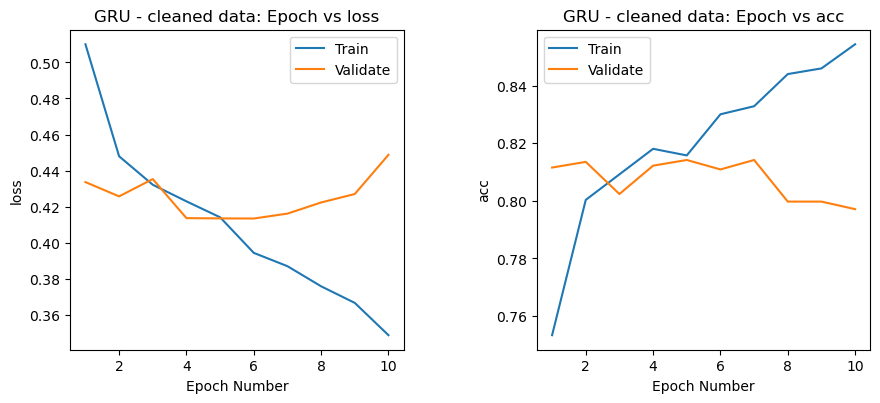

In [34]:
history6 = model6.fit(pad_seq2, y_train, validation_split = .2,epochs = 10, verbose = 1)
modelGraphs(history6, "GRU - cleaned data")

All the plots show a similar trend: the train accuracy continues to go up over the epochs, but the vaildation accuracy remains mostly constant. This shows that there is little benefit to continue training past the first couple epochs. 

# Results

In [94]:
def make_pred(model,seq,seq_test, model_num):
    '''
    This function makes predictions based on the training set
    and the testing set.
    It calculates the F1 score for the training set (includes the validation data)
    and it creates the submission file for Kaggle for the test predictions. 
    '''
    #predict the training set
    yp = model.predict(seq)
    #convert predictions to 0 and 1 from continuous
    yp = [1 if ele > 0.5 else 0 for ele in yp]

    #calculate the F1 score for the training data
    f1[model_num] = round(f1_score(yp,y_train),4)
    print("F1 score for training and validation sets: ",f1[model_num])
    
    #make confusion matrix
    disp = ConfusionMatrixDisplay.from_predictions(y_train,yp,xticks_rotation='vertical')
    fig = disp.figure_
    fig.set_figwidth(4)
    fig.set_figheight(4) 
    plt.show
    
    #predict the test set
    yp_test = model.predict(seq_test)
    #convert predictions to 0 and 1 from continuous
    yp_test = [1 if ele > 0.5 else 0 for ele in yp_test]
    
    #make a submission df with id and predictions
    submission = pd.DataFrame()
    submission['id'] = test_data1['id']
    submission['target'] = yp_test

    #save submissions df as csv to submit to Kaggle
    submission.to_csv('submission' + str(model_num) + '.csv',index=False)

In [95]:
#initialize result variables for use in table
mod = ['','','','','','']
cln_data = ['','','','','','']
train_acc = np.zeros(6)
val_acc = np.zeros(6)
train_loss = np.zeros(6)
val_loss = np.zeros(6)
f1 = np.zeros(6)

238/238 [==============================] - 1s 4ms/step
F1 score for training and validation sets:  0.8623
102/102 [==============================] - 0s 4ms/step


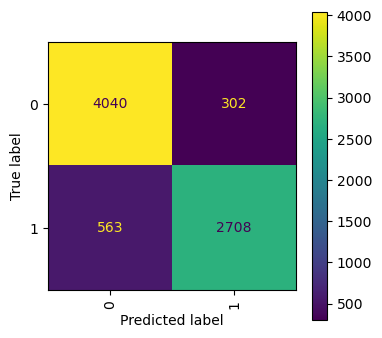

In [96]:
#make predictions for first model
mod_num = 0
make_pred(model1,pad_seq,pad_seq_test,mod_num)

#save info to variables for use in tables
mod[mod_num] = 'Simple RNN'
cln_data[mod_num] = 'N'
train_acc[mod_num] = history1.history['acc'][-1]
train_loss[mod_num] = history1.history['loss'][-1]
val_acc[mod_num] = history1.history['val_acc'][-1]
val_loss[mod_num] = history1.history['val_loss'][-1]

#kaggle score: 0.77076

238/238 [==============================] - 2s 10ms/step
F1 score for training and validation sets:  0.8447
102/102 [==============================] - 1s 9ms/step


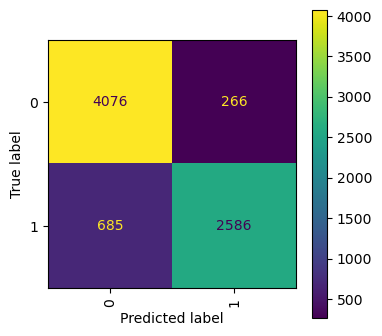

In [97]:
#make predictions for second model
#and save info to variables for use in tables
mod_num = 1
make_pred(model2,pad_seq,pad_seq_test,mod_num)
mod[mod_num] = 'LSTM'
cln_data[mod_num] = 'N'
train_acc[mod_num] = history2.history['acc'][-1]
train_loss[mod_num] = history2.history['loss'][-1]
val_acc[mod_num] = history2.history['val_acc'][-1]
val_loss[mod_num] = history2.history['val_loss'][-1]

#kaggle score: 0.80876

238/238 [==============================] - 2s 8ms/step
F1 score for training and validation sets:  0.8251
102/102 [==============================] - 1s 6ms/step


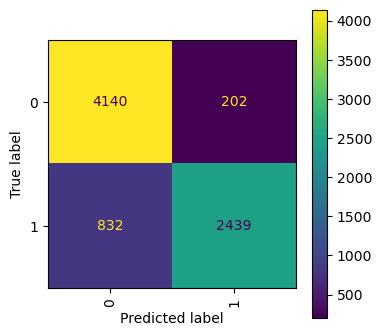

In [98]:
#make predictions for third model
#and save info to variables for use in tables
mod_num = 2
make_pred(model3,pad_seq,pad_seq_test,mod_num)
mod[mod_num] = 'GRU'
cln_data[mod_num] = 'N'
train_acc[mod_num] = history3.history['acc'][-1]
train_loss[mod_num] = history3.history['loss'][-1]
val_acc[mod_num] = history3.history['val_acc'][-1]
val_loss[mod_num] = history3.history['val_loss'][-1]

#kaggle score: 0.80968

238/238 [==============================] - 1s 4ms/step
F1 score for training and validation sets:  0.8649
102/102 [==============================] - 0s 4ms/step


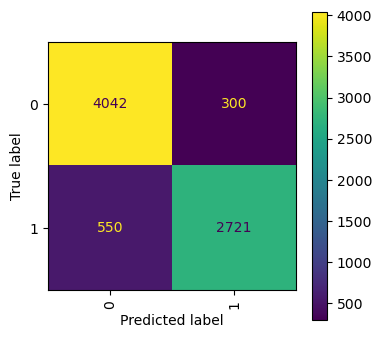

In [99]:
#make predictions for fourth model
#and save info to variables for use in tables
mod_num = 3
make_pred(model4,pad_seq2,pad_seq_test2,mod_num)
mod[mod_num] = 'Simple RNN'
cln_data[mod_num] = 'Y'
train_acc[mod_num] = history4.history['acc'][-1]
train_loss[mod_num] = history4.history['loss'][-1]
val_acc[mod_num] = history4.history['val_acc'][-1]
val_loss[mod_num] = history4.history['val_loss'][-1]

#kaggle score: 0.76953

238/238 [==============================] - 2s 10ms/step
F1 score for training and validation sets:  0.839
102/102 [==============================] - 1s 9ms/step


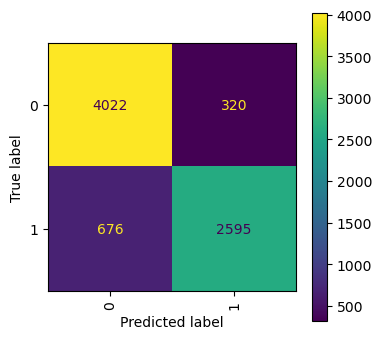

In [100]:
#make predictions for fifth model
#and save info to variables for use in tables
mod_num = 4
make_pred(model5,pad_seq2,pad_seq_test2,mod_num)
mod[mod_num] = 'LSTM'
cln_data[mod_num] = 'Y'
train_acc[mod_num] = history5.history['acc'][-1]
train_loss[mod_num] = history5.history['loss'][-1]
val_acc[mod_num] = history5.history['val_acc'][-1]
val_loss[mod_num] = history5.history['val_loss'][-1]

#kaggle score: 0.81397

238/238 [==============================] - 2s 7ms/step
F1 score for training and validation sets:  0.8365
102/102 [==============================] - 1s 8ms/step


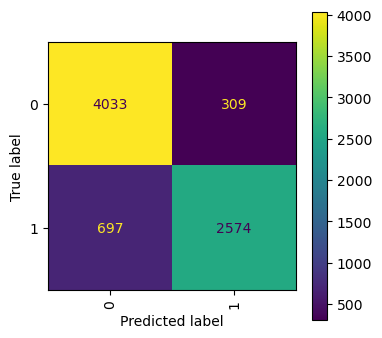

In [101]:
#make predictions for sixth model
#and save info to variables for use in tables
mod_num = 5
make_pred(model6,pad_seq2,pad_seq_test2,mod_num)
mod[mod_num] = 'GRU'
cln_data[mod_num] = 'Y'
train_acc[mod_num] = history6.history['acc'][-1]
train_loss[mod_num] = history6.history['loss'][-1]
val_acc[mod_num] = history6.history['val_acc'][-1]
val_loss[mod_num] = history6.history['val_loss'][-1]

#kaggle score: 0.80478

In [66]:
#put results into variables for table
#f1 test results from Kaggle
f1_test = [0.77076,0.80876,0.80968,0.76953,0.81397,0.80478]

#make results table
results = pd.DataFrame(list(zip(mod,cln_data,train_loss,train_acc,val_loss,val_acc,f1,f1_test)),
                       columns = ['Model','Clean Data?','Training Loss','Training Accuracy', 'Validation Loss',
                                  'Validation Accuracy', 'Train/Validation F1', 'Test set F1 score'])
results

,Model,Clean Data?,Training Loss,Training Accuracy,Validation Loss,Validation Accuracy,Train/Validation F1,Test set F1 score
0,Simple RNN,N,0.295978,0.877340,0.531298,0.791202,0.8623,0.77076
1,LSTM,N,0.335023,0.856158,0.441986,0.808930,0.8447,0.80876
2,GRU,N,0.352046,0.848276,0.428464,0.803677,0.8251,0.80968
3,Simple RNN,Y,0.281641,0.885714,0.561116,0.777413,0.8649,0.76953
4,LSTM,Y,0.339352,0.852217,0.449187,0.806960,0.8390,0.81397
5,GRU,Y,0.348749,0.854351,0.448750,0.797111,0.8365,0.80478


The best model according to the F1 score on the test data was the LSTM model using clean data. However, all 4 of the LSTM and GRU models performed very similarly. The Simple RNN models performed the worst, which was expected since we know Simple RNN is not the best architecture, and LSTM and GRU were made to overcome some of its limitations. It is suprising to see that cleaning the data did not have much impact on the results. 

The confusion matrixs show that there is a pretty consistent number of false positives and false negatives. All models have more false negatives than false positives, this makes sense since there are more negatives (0) then positives (1) in the dataset. The GRU model with the "original" data had the most false negatives and led to the worst F1 score on the trainind data. 

Many different hyperparameters were trialed during an initial stage of testing. Many different units for the RNN layers, different combinations of RNN layers, different compilers, among others. The six shown above are a representation of what was trialed.


# Conclusions

Recurrent neural networks are a powerful tool for sequential data. In this situation, a RNN was able to do a fairly good job differntiating between actual disaster tweets, and non-disaster tweets. We were able to achieve an F1 score of ~0.81 with LSTM and GRU RNN architectures. Tweets are a challenging case for RNN and machine learning in general. They contain a lot of slang, abbreviations, inside-jokes, emjois, and special characters which are challenging to accurately capture in a model. They are also very short in length which means each tweet does not have a lot of context to pull from. English words can have so many different meanings in different use cases that it can be very challenging to distinguish the meaning of a word from such little context.

Utilizing the more advanced architetures helped the model's performance, while cleaning the data did not seem to help. There are numerous additional things that could be attempted to improve the model. First, we could look into including some of the features we looked at the beggining such as word count, character count, and average word length, among other meta-data features. These features could provide some further information to the model. Second, there are numerous other preprocessing and cleaning steps we could trial. Third, we could try to add more layers, try a different embedding matrix, or try tuning different hyperparameters. Lastly, and most importantly, we can try to get more data. Judging by the leaderboard, most scores are in the low to mid 80s. This seems like almost a ceiling on a models performance given the data in the challenge. The dataset only includes 10,000 samples, with 7,613 samples as training. If we were able to gather significantly more data, this could give the model much more to learn from. Obviously, more data is (almost) always better, but it can be challenging and time-consuming (costly) to get more data.


# References
The following notebooks and websites for very helpful:
* https://towardsdatascience.com/understanding-word-embeddings-with-tf-idf-and-glove-8acb63892032
* https://www.kaggle.com/code/tuckerarrants/disaster-tweets-eda-glove-rnns-bert
* https://www.kaggle.com/code/anmolstha/disaster-tweets-simple-rnn-implementation
* https://www.geeksforgeeks.org/pre-trained-word-embedding-using-glove-in-nlp-models/